In [1]:
import numpy as np # linear algebra
import pandas as pd 

In [2]:
import os
import shutil
import itertools
import pathlib
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix , classification_report

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

In [15]:
train_data_path = '../train/train'
filepaths =[]
labels = []

folds = os.listdir(train_data_path)
for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [17]:
test_data_path = '../test/test'
filepaths =[]
labels = []

folds = os.listdir(test_data_path)
for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [18]:
train_df.head()

,filepaths,label
0,../train/train\false\1.png,false
1,../train/train\false\10.png,false
2,../train/train\false\100.png,false
3,../train/train\false\1000.png,false
4,../train/train\false\1001.png,false


In [21]:
test_df.head()

,filepaths,label
0,../test/test\false\1.png,false
1,../test/test\false\10.png,false
2,../test/test\false\100.png,false
3,../test/test\false\101.png,false
4,../test/test\false\102.png,false


In [19]:
train_df.shape

(4438, 2)

In [20]:
test_df.shape

(1114, 2)

Spliting and Preprocessing images

In [13]:
valid,test = train_test_split(test_df,train_size= 0.5,shuffle=True,random_state=45)

In [22]:
img_size = (224,224)
batch_size = 16
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df ,
                                       x_col = 'filepaths' ,
                                       y_col = 'label' ,
                                       target_size = img_size ,
                                      class_mode = 'categorical' ,
                                       color_mode = 'rgb' ,
                                       shuffle = True ,
                                       batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid ,
                                       x_col = 'filepaths' ,
                                       y_col = 'label' ,
                                       target_size = img_size , 
                                       class_mode = 'categorical',
                                       color_mode = 'rgb' ,
                                       shuffle= True,
                                       batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test ,
                                      x_col= 'filepaths' ,
                                      y_col = 'label' ,
                                      target_size = img_size , 
                                      class_mode = 'categorical' ,
                                      color_mode= 'rgb' ,
                                      shuffle = False ,
                                      batch_size = batch_size)

Found 4438 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.
Found 2219 validated image filenames belonging to 2 classes.


Display a Sample of Images with Their Corresponding Classes

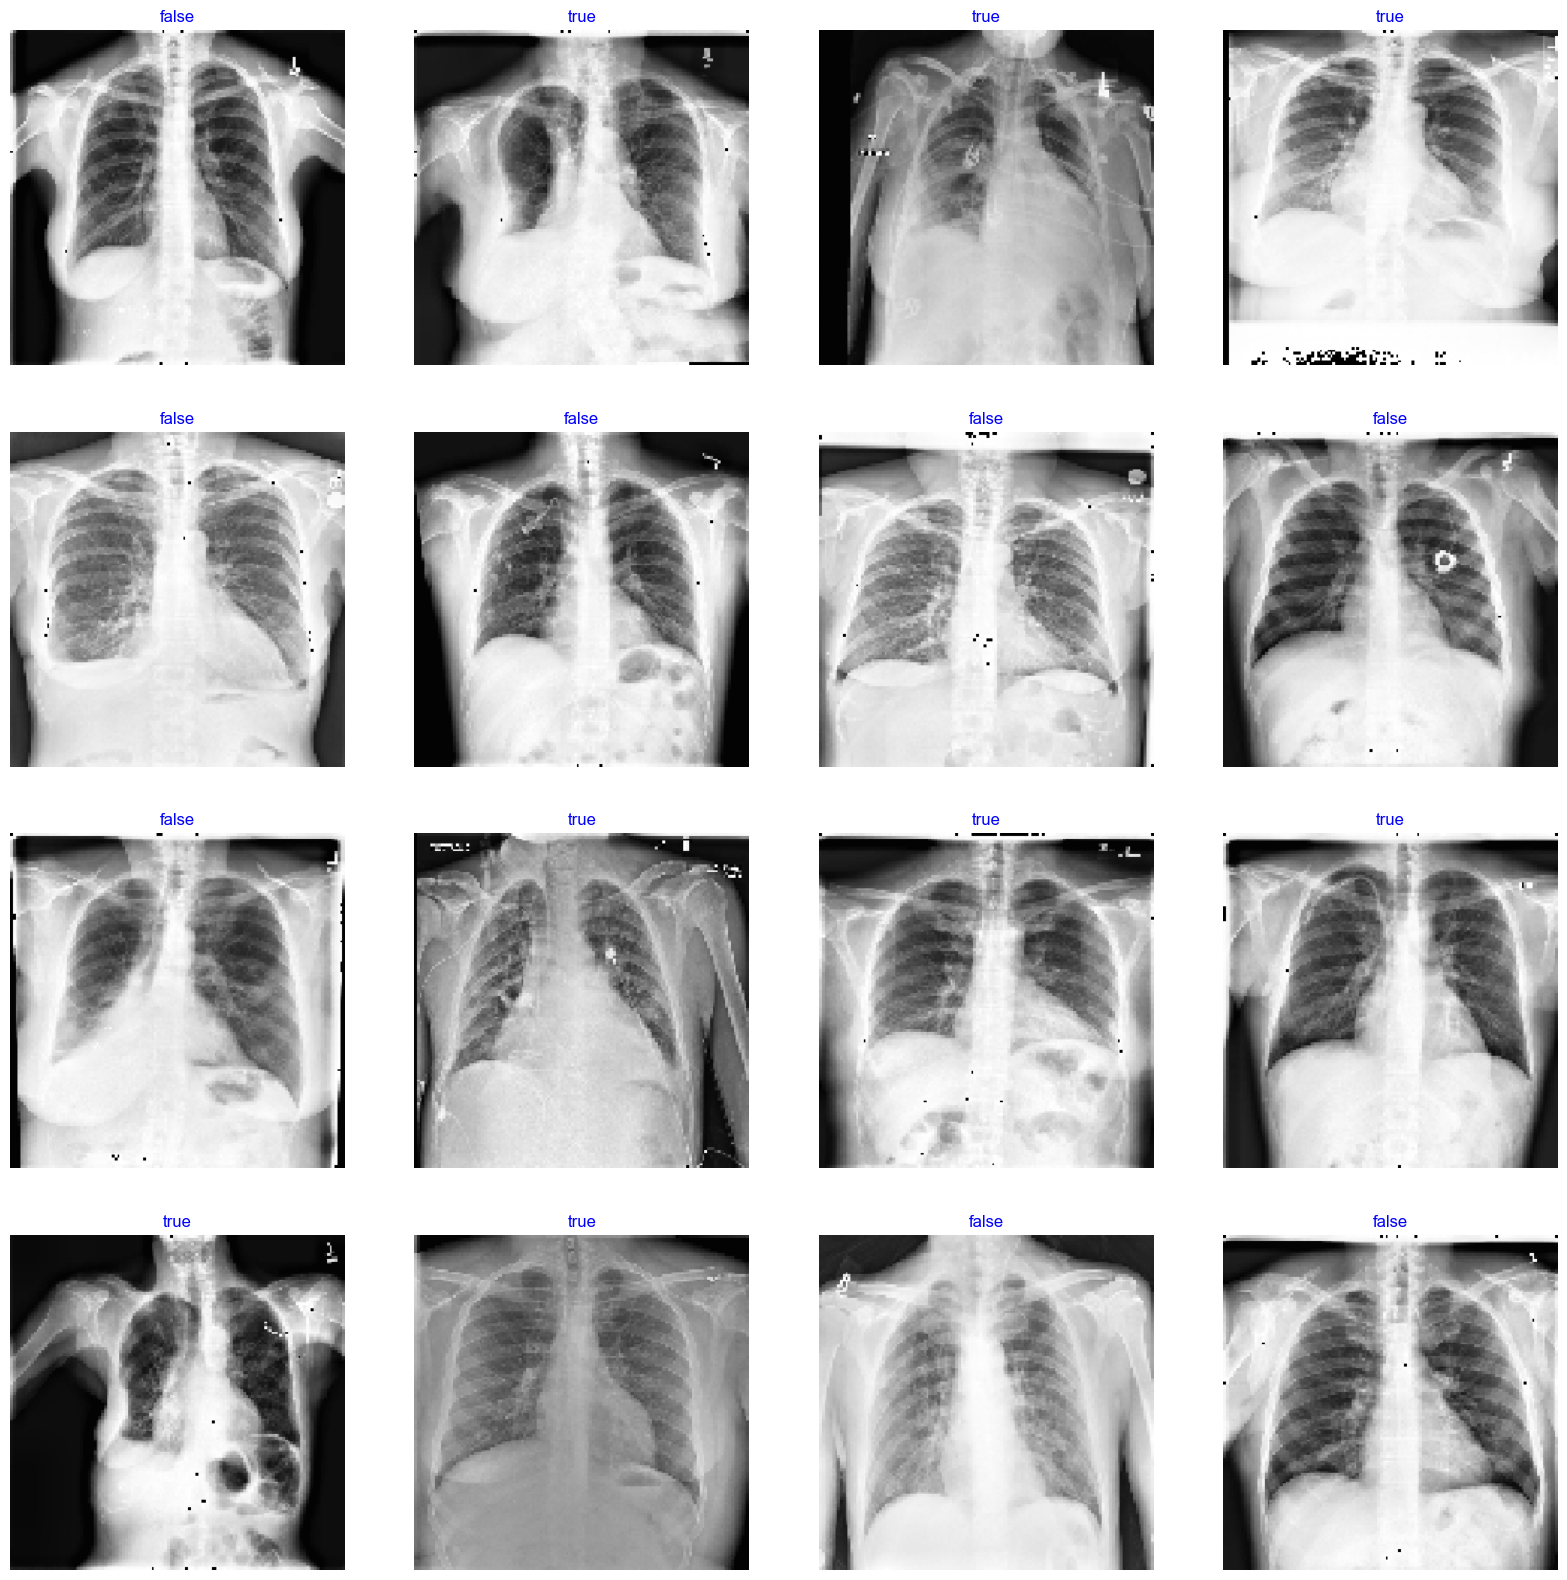

In [23]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show()

Model Training

In [24]:
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet',
                                                  input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),  # Removed regularization
    Dropout(0.2),  # Reduced dropout
    Dense(num_class, activation='softmax')
])

model.compile(optimizer=Adamax(learning_rate=0.0005),  # Lower learning rate
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,764,057 (247.06 MB)

 Trainable params: 64,448,210 (245.85 MB)

 Non-trainable params: 315,847 (1.20 MB)

In [ ]:
Epochs = 5

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 2887s 10s/step - accuracy: 0.5941 - loss: 0.9741 - val_accuracy: 0.7350 - val_loss: 0.5365
Epoch 2/5
117/278 ━━━━━━━━━━━━━━━━━━━━ 18:21 7s/step - accuracy: 0.7700 - loss: 0.5344

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

In [ ]:
plt.figure(figsize=(20, 8))
plt.style.use("ggplot")

#Loss plot
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r--', linewidth=2, marker='o', label='Training Loss')
plt.plot(Epochs, val_loss, 'b--', linewidth=2, marker='o', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='purple', edgecolors='black', label=loss_label)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

#Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r--', linewidth=2, marker='o', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'b--', linewidth=2, marker='o', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='purple', edgecolors='black', label=acc_label)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Confusion Matrix

In [ ]:
preds = model.predict(test_gen)  
y_pred = np.argmax(preds, axis=1)
# Get class labels
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Compute Confusion Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=classes, yticklabels=classes, linewidths=0.5)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
model.save("CNN_ model.h5")
